# ISMIR 2020: Schema Instance Classification

This notebook is used to generate the results presented in the paper.

## Data Loading

In [1]:
import Pkg; Pkg.activate(".."); Pkg.instantiate();

 Activating environment at `~/Uni/phd/code/schemata_code/Project.toml`


In [2]:
include("../src/classify.jl");
pgfplotsx(); # replace this by gr() or plotlyjs() if TeX is not installed
# gr();
# plotlyjs();

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5161493776131374043\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-5917396315539321329\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5161493776131374043\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [3]:
# setup

corpusdir = "../schema_annotation_data/data/mozart_sonatas/"; # TODO: fix this for the final notebook

lex = Polygrams.loadlexicon(joinpath(corpusdir, "..", "lexicon.json"));

# TODO: select schemata
ismirschemas = [
    "doremi.2", # 5
    "fenaroli.2", # 10
    "fenaroli.2.min", # 3
    #"fenaroli.2.basscanon", # 0
    "fenaroli.2.basscanon.min", # 1
    #"fenaroli.2.durante",
    #"fenaroli.2.durante.min",
    "fenaroli.2.flipped", # 43
    "fenaroli.2.flipped.min", # 8
    "fenaroli.2.melcanon", # 6
    "fenaroli.2.melcanon.min", # 2
    #"folia.2", # 0
    "fonte.2", # 49
    "fonte.2.flipped", # 2
    "fonte.2.majmaj", # 8
    #"grandcad.2", # 0
    "indugio.2", # 9
    "indugio.2.voiceex", # 5
    "lamento.2", # 2
    "lully.2", # 2
    "morte.2", # 1
    "prinner.2", # 32
    "quiescenza.2", # 46
    "quiescenza.2.diatonic", # 6
    "solfami.2" # 4
];

In [4]:
# loading and cleaning

df, notelists, foldednotedicts, tsigs =
    loadcorpusdata(corpusdir, ismirschemas);

df = cleancorpusdata(df, lex, foldednotedicts)
df = findgroups(df)
df = findfullcontexts(df, notelists)

describe(df)

loading pieces...100%|██████████████████████████████████| Time: 0:00:53
┌ Warning: excludingincorrect instance for quiescenza.2 in K279-1:
│ ErrorException("found inconsistent schema stage 2: TimedNote{SpelledInterval,Rational{Int64}}[Note#note290<50//1-401//8>(C2), Note#note294<809//16-405//8>(C4), Note#note281<401//8-201//4>(A4)] in SpelledIC[P1 m7; P1 M6; P1 M7; P1 P1].")
└ @ Main /home/chfin/Uni/phd/code/schemata_code/src/classify.jl:197
┌ Warning: excludingincorrect instance for fenaroli.2.min in K282-3:
│ ErrorException("found inconsistent schema stage 3: TimedNote{SpelledInterval,Rational{Int64}}[Note#note609<191//4-765//16>(D4)] in SpelledIC[P1 d5; m2 d4; m3 P1; d4 m2].")
└ @ Main /home/chfin/Uni/phd/code/schemata_code/src/classify.jl:197
┌ Warning: excludingincorrect instance for fenaroli.2 in K283-2:
│ ErrorException("found inconsistent schema stage 3: TimedNote{SpelledInterval,Rational{Int64}}[Note#note141<149//8-299//16>(D4)] in SpelledIC[P1 d5; m2 P4; m3 P1; P4 m2].")
└ @ 

finding contexts...100%|████████████████████████████████| Time: 0:01:190:47


,variable,mean,min,median,max
,Symbol,Union…,Any,Union…,Any
1,notesraw,,,,
2,isinstance,0.0012759,0,0.0,1
3,beatfactor,4.4387,2.0,4.0,8.0
4,timesigs,,TimePartition:0//1<(4/4)>100//1,,TimePartition:0//1<(2/4)>189//2
5,piece,,K279-1,,K576-3
6,schema,,doremi.2,,morte.2
7,notes,,,,
8,noteswritten,,,,
9,overlap,114.346,1,107.0,244


In [5]:
# basic statistics
n = size(df)[1]
npos = count(df.isinstance)

println("data points: ", n)
println("positives: $npos ($(npos/n))")
println("negatives: $(n-npos) ($(1-(npos/n)))")

println("total number of notes: ", sum(length.(values(foldednotedicts))))

sort(by(df, :schema, instances=:isinstance=>count), :schema)

data points: 191238
positives: 244 (0.0012758970497495268)
negatives: 190994 (0.9987241029502505)
total number of notes: 103829


,schema,instances
,Categorical…,Int64
1,doremi.2,5
2,fenaroli.2,10
3,fenaroli.2.min,3
4,fenaroli.2.basscanon.min,1
5,fenaroli.2.flipped,43
6,fenaroli.2.flipped.min,8
7,fenaroli.2.melcanon,6
8,fenaroli.2.melcanon.min,2
9,fonte.2,49


## Features

In [6]:
# define the set of "independent" features
# which don't depend on training data

features = Dict(
    :mweight => row -> mWeight(row.noteswritten, get(row.timesigs)),
    :dur =>     row -> getDuration(row.notes, row.beatfactor),
    :vdist =>   row -> Polygrams.voicedist(row.notes),
    #:sskip =>   row -> stageSkip(row.notes, row.beatfactor),
    :rdsums =>  row -> rhythmDistanceSumInEvent(row.notes, row.beatfactor),
    :rdsumv =>  row -> rhythmDistanceSumInVoice(row.notes, row.beatfactor),
    :onsets =>  row -> onsetsinstage(row.notes, row.context),
    :rreg =>    row -> rhythmicirregularity(row.notes, row.beatfactor),
    :mreg   =>  row -> metricirregularity(row.notes, row.beatfactor),
    :pdsums =>  row -> pitchDistanceSumInEvent(row.notes),
    :pdsumv =>  row -> pitchDistanceSumInVoice(row.notes),
    :preg =>    row -> pitchirregularity(row.notes),
)

indepfeatnames = [:rreg, :mreg, :preg,
                  :rdsums, :rdsumv, :pdsums, :pdsumv,
                  :mweight, :dur, :onsets, :vdist] # independent feature names
featnames = [:profiledist, indepfeatnames...]; # all feature names

In [7]:
# run the features on the whole dataset
df = runfeatures(df, features);
describe(df[!,indepfeatnames])

running feature preg	100%|██████████████████████████████| Time: 0:00:01m
running feature pdsums	100%|████████████████████████████| Time: 0:00:00
running feature mreg	100%|██████████████████████████████| Time: 0:00:089:15
running feature dur	100%|███████████████████████████████| Time: 0:00:01m
running feature mweight	100%|███████████████████████████| Time: 0:00:03:12
running feature rdsums	100%|████████████████████████████| Time: 0:00:01
running feature rdsumv	100%|████████████████████████████| Time: 0:00:01m
running feature vdist	100%|█████████████████████████████| Time: 0:00:02:05
running feature onsets	100%|████████████████████████████| Time: 0:00:05:43
running feature rreg	100%|██████████████████████████████| Time: 0:00:059:54
running feature pdsumv	100%|████████████████████████████| Time: 0:00:00


,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,rreg,0.615585,0.0,0.472222,4.25,,,Float64
2,mreg,7.8632,0.0,7.14583,40.3333,,,Float64
3,preg,0.150294,0.0,0.0833333,1.0,,,Float64
4,rdsums,0.796879,0.0,0.625,6.375,,,Float64
5,rdsumv,4.48446,0.0,4.10417,20.6667,,,Float64
6,pdsums,0.4718,0.0,0.5,3.5,,,Float64
7,pdsumv,6.59084,0.833333,6.16667,25.5833,,,Float64
8,mweight,1.05086,0.0078125,0.984375,4.0,,,Float64
9,dur,4.45822,0.0,4.0,36.8333,,,Float64


## Training and Evaluation

In [8]:
# define the training pipeline

function pipeline(dftrain, dftest)
    # train and run features that depend on training data
    info = trainfeatures(dftrain)
    dftrain = rundepfeatures(dftrain, info)
    dftest  = rundepfeatures(dftest,  info)
    
    # upsample the dataset to balance the classes
    dfutrain = upsample(dftrain)
    dfutest  = upsample(dftest)
    
    # fit the model
    modelu = fitmodel(dfutrain, featnames)
    # TODO: add other models
    
    # make predictions
    dfupred = addpredictions(dfutest, modelu) # on balanced data
    dfpredcorr = addpredictions(dftest, modelu)
    dfpred = addpredictions(dftest, modelu; corrinter=0)
    
    println(modelu)
    println()
    showeval(dfupred)
    println()
    
    return dfupred, dfpredcorr, dfpred, modelu
end

pipeline (generic function with 1 method)

In [9]:
# run the crossvalidation and collect the data

crossdata = crossval(pipeline, df, 5);

dfupred = vcat(getindex.(crossdata, 1)...);
dfpredcorr = vcat(getindex.(crossdata, 2)...);
dfpred = vcat(getindex.(crossdata, 3)...);
models = getindex.(crossdata, 4);

Running fold 1...
StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Bernoulli{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

isinstance ~ 1 + profiledist + rreg + mreg + preg + rdsums + rdsumv + pdsums + pdsumv + mweight + dur + onsets + vdist

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error     z value  Pr(>|z|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)   9.12402    0.0640535    142.444      <1e-99   8.99848     9.24956
profiledist  -7.5622     0.0582087   -129.915      <1e-99  -7.67628    -7.44811
rreg         -4.88078    0.0479058   -101.883      <1e-99  -4.97467    -4.78689
mreg          0.874514   0.0447132     19.5583     <1e-84   0.786878    0.96215
preg         -1.75316    0.0665729    -26.3344     <1e-99  -1.88364    

### Direct Evaluation

In [10]:
# overall evaluation

showeval(dfupred)
evaltex(dfupred)

confusion matrix:
true positives:  171400
true negatives:  169867
false positives: 21107
false negatives: 19574

accuracy:	0.8934907369589578
precision:	0.8903572337629281
recall:		0.897504372322934
f1-score:	0.8939165173763497
MCC:		0.7870068305356148
171400 & 169867 & 21107 & 19574 & 0.893 & 0.890 & 0.898 & 0.894 & 0.787\\

In [11]:
showeval(dfpred)
evaltex(dfpred)

confusion matrix:
true positives:  219
true negatives:  169867
false positives: 21107
false negatives: 25

accuracy:	0.8894873913543704
precision:	0.010269155022038826
recall:		0.8975409836065574
f1-score:	0.020305980528511822
MCC:		0.0892535668418585
219 & 169867 & 21107 & 25 & 0.889 & 0.010 & 0.898 & 0.020 & 0.089\\

In [12]:
showeval(dfpredcorr)
evaltex(dfpredcorr)

confusion matrix:
true positives:  15
true negatives:  190923
false positives: 51
false negatives: 229

accuracy:	0.9985357027058123
precision:	0.22727272727272727
recall:		0.06147540983606557
f1-score:	0.0967741935483871
MCC:		0.11763359563450183
15 & 190923 & 51 & 229 & 0.999 & 0.227 & 0.061 & 0.097 & 0.118\\

### Grouped Evaluation

In [13]:
groupdata(df) = by(df, :group, isinstance=:isinstance=>any, predbool=:predbool=>any)
dfupredgrp = groupdata(dfupred)
dfpredgrp = groupdata(dfpred)
dfpredcorrgrp = groupdata(dfpredcorr);

In [14]:
showeval(dfupredgrp) # note that grouping removes the effect of upsampling
evaltex(dfupredgrp)

confusion matrix:
true positives:  220
true negatives:  6009
false positives: 2663
false negatives: 12

accuracy:	0.6995732255166217
precision:	0.07630939993062782
recall:		0.9482758620689655
f1-score:	0.14125200642054572
MCC:		0.21829185341821922
220 & 6009 & 2663 & 12 & 0.700 & 0.076 & 0.948 & 0.141 & 0.218\\

In [15]:
showeval(dfpredgrp)
evaltex(dfpredgrp)

confusion matrix:
true positives:  220
true negatives:  6009
false positives: 2663
false negatives: 12

accuracy:	0.6995732255166217
precision:	0.07630939993062782
recall:		0.9482758620689655
f1-score:	0.14125200642054572
MCC:		0.21829185341821922
220 & 6009 & 2663 & 12 & 0.700 & 0.076 & 0.948 & 0.141 & 0.218\\

In [16]:
# this doesn't really make sense because it's not corrected to the right proportion
showeval(dfpredcorrgrp)
evaltex(dfpredcorrgrp)

confusion matrix:
true positives:  17
true negatives:  8653
false positives: 19
false negatives: 215

accuracy:	0.9737196765498652
precision:	0.4722222222222222
recall:		0.07327586206896551
f1-score:	0.12686567164179102
MCC:		0.17845014594929443
17 & 8653 & 19 & 215 & 0.974 & 0.472 & 0.073 & 0.127 & 0.178\\

In [17]:
# run the predictions again but correct for the imbalance of the grouped data
preds = map(getindex.(crossdata, 3), models) do dfpart, model
    dfpartgrp = groupdata(dfpart)
    prop = count(dfpartgrp.isinstance) / size(dfpartgrp)[1]
    dfpart = addpredictions(dfpart, model; tau=prop)
    dfpart
end
dfpredcorr2 = vcat(preds...)
dfpredcorr2grp = groupdata(dfpredcorr2)
showeval(dfpredcorr2grp)
evaltex(dfpredcorr2grp)

confusion matrix:
true positives:  43
true negatives:  8596
false positives: 76
false negatives: 189

accuracy:	0.9702380952380952
precision:	0.36134453781512604
recall:		0.1853448275862069
f1-score:	0.245014245014245
MCC:		0.2449645334146098
43 & 8596 & 76 & 189 & 0.970 & 0.361 & 0.185 & 0.245 & 0.245\\

## Model Inspection

In [18]:
# fit the model again, this time on the full data
# # dependent features are still based on the cross-validation splits

info = trainfeatures(df);
dfcomplete = rundepfeatures(df, info);

In [19]:
dfucomplete = upsample(dfcomplete)
dfdcomplete = downsample(dfcomplete)
model = fitmodel(dfucomplete, featnames)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Bernoulli{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

isinstance ~ 1 + profiledist + rreg + mreg + preg + rdsums + rdsumv + pdsums + pdsumv + mweight + dur + onsets + vdist

Coefficients:
────────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error    z value  Pr(>|z|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)   9.498      0.0581969    163.205     <1e-99   9.38394     9.61207
profiledist  -8.13836    0.0541527   -150.285     <1e-99  -8.2445     -8.03223
rreg         -5.4422     0.0445618   -122.127     <1e-99  -5.52954    -5.35486
mreg          1.1818     0.0389395     30.3496    <1e-99   1.10548     1.25812
preg         -2.59724    0.0594105    -43.7169    <1e-99  -2.71368    -2.4808
rdsums        6.57

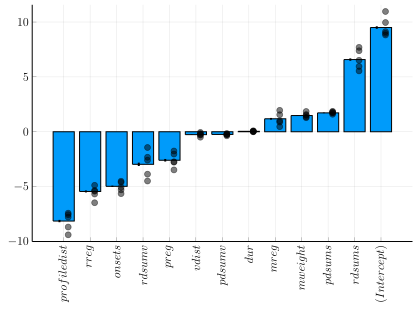

In [20]:
cnames = plotmodel(model; xrotation=90, typ=:bar, tickfontsize=12, tickfonthalign=:hcenter, legend=false)
pointdict = Dict(zip(coefnames(model), eachrow(hcat(coef.(models)...))))
points = vcat((pointdict[n]' for n in cnames)...)
n = size(points)[1]
modelplot = plot!([x - 0.33 for x in 1:n], points ; typ=:scatter, color=:black, alpha=0.5)

In [21]:
savefig(modelplot, "modelplot.tex")
savefig(modelplot, "modelplot.pdf")

In [22]:
dfucomplete = addpredictions(dfucomplete, model)
showeval(dfucomplete)

confusion matrix:
true positives:  172153
true negatives:  169730
false positives: 21244
false negatives: 18821

accuracy:	0.8951035219453957
precision:	0.8901534149960961
recall:		0.9014473174358814
f1-score:	0.8957647689341808
MCC:		0.790270653346119


In [23]:
dfcomplete = addpredictions(dfcomplete, model; corrinter=0);

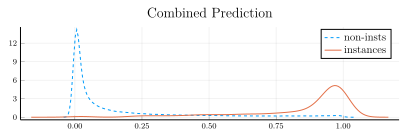

In [24]:
predplt = plotcol(dfcomplete, :pred;
                  group=:isinstance, label=["non-insts" "instances"],
                  title="Combined Prediction",
                  size=(600,200), lw=1,
                  ls=[:dash :solid], legend=:topright, legendfontsize=11)

In [25]:
savefig(predplt, "preddist.tex")
savefig(predplt, "preddist.pdf")

In [26]:
featplts = featureplots(dfcomplete, featnames; group=:isinstance,# width=600, height=150,
                        labels=["non-insts" "instances"], title="",
                        ls=[:dash :solid], lw=1,
                        titlefontsize=14, legendfontsize=11)

12-element Array{Plots.Plot{Plots.PGFPlotsXBackend},1}:
 Plot{Plots.PGFPlotsXBackend() n=2}
 Plot{Plots.PGFPlotsXBackend() n=2}
 Plot{Plots.PGFPlotsXBackend() n=2}
 Plot{Plots.PGFPlotsXBackend() n=2}
 Plot{Plots.PGFPlotsXBackend() n=2}
 Plot{Plots.PGFPlotsXBackend() n=2}
 Plot{Plots.PGFPlotsXBackend() n=2}
 Plot{Plots.PGFPlotsXBackend() n=2}
 Plot{Plots.PGFPlotsXBackend() n=2}
 Plot{Plots.PGFPlotsXBackend() n=2}
 Plot{Plots.PGFPlotsXBackend() n=2}
 Plot{Plots.PGFPlotsXBackend() n=2}

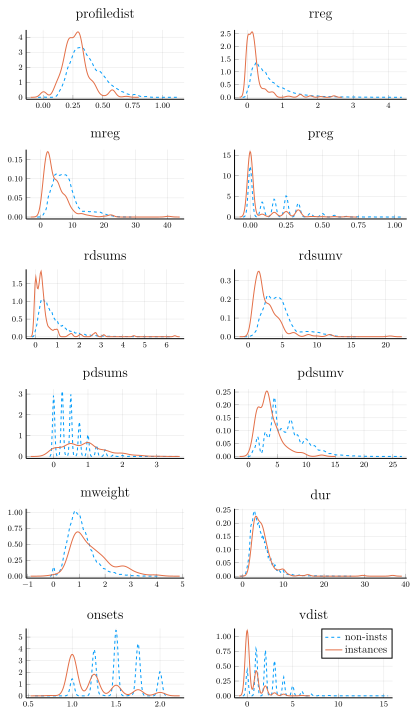

In [27]:
distplt = plot(featplts...; layout=grid(6,2), size=(600,1000))

In [28]:
savefig(distplt, "featdist.tex")
savefig(distplt, "featdist.pdf")

## Inspecting Misclassified Matches

In [29]:
wrong = confidentfps(dfpred[.! dfpred.groupisinstance,:])

,piece,schema,notestring
,Categorical…,Categorical…,String
1,K332-3,quiescenza.2.diatonic,"note509,note511;note512,note525;note527,note547;note555,note559"
2,K332-3,quiescenza.2.diatonic,"note509,note511;note512,note525;note527,note543;note555,note559"
3,K332-3,quiescenza.2.diatonic,"note2346,note2348;note2349,note2362;note2364,note2384;note2392,note2396"
4,K332-3,quiescenza.2.diatonic,"note2345,note2348;note2349,note2362;note2364,note2384;note2392,note2396"
5,K332-3,quiescenza.2.diatonic,"note508,note511;note512,note525;note527,note543;note555,note559"
6,K311-3,indugio.2,"note3040,note3022;note3046,note3036;note3061,note3045;note3074,note3063"
7,K332-3,quiescenza.2.diatonic,"note2345,note2348;note2349,note2362;note2364,note2380;note2392,note2396"
8,K311-3,indugio.2,"note599,note583;note605,note592;note620,note604;note631,note622"
9,K332-3,quiescenza.2,"note2345,note2353;note2349,note2362;note2364,note2384;note2392,note2396"


In [30]:
wrong[wrong.schema .== "fonte.2", [:piece, :notestring, :pred]]

,piece,notestring
,Categorical…,String
1,K283-3,"note1337,note1331;note1348,note1341;note1364,note1349;note1376,note1367"
2,K283-3,"note1337,note1331;note1348,note1341;note1364,note1349;note1381,note1367"
3,K570-3,"note642,note647;note640,note654;note658,note673;note690,note695"
4,K570-3,"note642,note647;note640,note654;note658,note673;note676,note695"
5,K333-3,"note2716,note2703;note2718,note2705;note2742,note2723;note2746,note2732"
6,K281-2,"note240,note254;note257,note255;note265,note282;note292,note303"
7,K570-3,"note642,note647;note640,note654;note658,note673;note676,note699"
8,K283-3,"note1337,note1331;note1350,note1341;note1364,note1349;note1381,note1367"
9,K333-3,"note2716,note2703;note2718,note2705;note2742,note2726;note2746,note2732"
